# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

 1. Entendimento do Desafio que você quer resolver
 2. Entendimento da Empresa/Área
 3. Extração/Obtenção de Dados
 4. Ajustes de Dados (Limpeza de Dados) 
 5. Análise Exploratória 
 6. Modelagem + Algoritmos modelo 
 7. Interpretação dos Resultados 
 8. Deploy/Produção


### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib  
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt   # permite percorrer todas os arquivos de um diretório
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split


In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6,
         'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('datasets') #define o caminho para a pasta datasets

dataframes = [] #cria uma lista vazia para armazenar os dataframes

for arquivo in caminho_bases.iterdir(): #iterdir() percorre todos os arquivos do diretório datasets

    nome_mes = arquivo.name[:3] #extrai os 3 primeiros caracteres do nome do arquivo, que representam o mês
    mes = meses[nome_mes] #converte o nome do mês para o número correspondente

    ano = arquivo.name[-8:] #extrai os últimos 8 caracteres do nome do arquivo, que representam o ano
    ano = int(ano.replace('.csv', '')) #remove a extensão .csv e converte para inteiro

    df = pd.read_csv(caminho_bases / arquivo.name) #lê cada arquivo CSV do diretório e concatena o caminho ex: 'datasets/arquivo.csv'
    df['mes'] = mes #adiciona a coluna 'mês' ao dataframe lido
    df['ano'] = ano #adiciona as colunas 'mês' e 'ano' ao dataframe lido
    dataframes.append(df) #adiciona o dataframe lido à lista dataframes ex: dataframes = [datasets/arquivo1.csv, datasets/arquivo2.csv, ...]
    

base_airbnb = pd.concat(dataframes,ignore_index=True) #concatena todos os dataframes da lista em um único dataframe 
display(base_airbnb)

C:\Users\leuci\AppData\Local\Temp\ipykernel_16464\2669022017.py:16: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name) #lê cada arquivo CSV do diretório e concatena o caminho ex: 'datasets/arquivo.csv'
C:\Users\leuci\AppData\Local\Temp\ipykernel_16464\2669022017.py:16: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name) #lê cada arquivo CSV do diretório e concatena o caminho ex: 'datasets/arquivo.csv'
C:\Users\leuci\AppData\Local\Temp\ipykernel_16464\2669022017.py:16: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name) #lê cada arquivo CSV do diretório e concatena o caminho ex: 'datasets/arquivo.csv'
C:\Users\leuci\AppData\Local\Temp\ipykernel_16464\2669022017.py:16: DtypeWarning: 

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


- Como temos muitas colunas, o nosso modelo pode acabar ficando mais lento
- Além disso uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso vamos excluir algumas colunas em nossa base
- Tipos de colunas que vamos excluir: 
1. IDs, Links e informações não relevantes para o modelo
2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo: Ex: Data x Ano/Mês)
3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
4. Colunas em que todos ou quase todos os valores são iguais
- Para isso, vamos criar um arquivoem excel com os 1.000 primeiros registros e fazer uma análise qualitativa

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [3]:
colunas_utilizadas = [
    'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count',
    'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
    'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'instant_bookable', 'is_business_travel_ready',
    'cancellation_policy', 'ano', 'mes'
]
base_airbnb = base_airbnb.loc[:, colunas_utilizadas] # seleciona apenas as colunas relevantes para a análise

In [4]:
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando
- Após a visualização inicial dos dados, identificamos uma grande quantidade de valores ausentes. Por esse motivo, decidimos remover da análise todas as colunas que apresentam mais de 300.000 valores nulos (NaN).

- Para as demais colunas, considerando que temos um volume elevado de dados (mais de 900.000 linhas), optamos por excluir todas as linhas que ainda contêm valores nulos.

In [5]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1) # remove colunas com mais de 300.000 valores nulos
print(base_airbnb.isnull().sum()) # exibe a quantidade de valores nulos por coluna

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [6]:
base_airbnb = base_airbnb.dropna() # remove todas as linhas que ainda contêm valores nulos
print(base_airbnb.shape)

(897709, 23)


In [7]:
print(base_airbnb.isnull().sum()) 

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [8]:
print(base_airbnb.dtypes) # exibe os tipos de dados de cada coluna do dataframe
print('-'*60)
print(base_airbnb.iloc[0]) # exibe a primeira linha do dataframe

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como as colunas price e extra_people estão sendo interpretadas como tipo object (em vez de float), é necessário converter essas colunas para o tipo numérico apropriado.

In [9]:
import numpy as np 

In [10]:

base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False) # converte a coluna 'price' para o tipo float32, float32 é um tipo de dado numérico de ponto flutuante de precisão simples, que ocupa menos espaço na memória do que o float64, o copy=False indica que a conversão deve ser feita sem criar uma cópia do objeto original, economizando memória

base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos de dados novamente
print(base_airbnb.dtypes) 

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Etapas da análise por feature:
Verificar a correlação entre as features e decidir se vamos manter todas ou remover algumas.

- Excluir outliers, utilizando como regra: Valores abaixo do limite inferior de Q1 - 1.5 × Amplitude e
 Valores acima do limite superior de Q3 + 1.5 × Amplitude
- Onde: Amplitude = Q3 - Q1

- Avaliar a relevância de cada feature no modelo, verificando se faz sentido mantê-la ou se devemos descartá-la.

- Abordagem por tipo de dado:
Iniciaremos pelas colunas de preço (variável alvo) e extra_people, por serem variáveis numéricas contínuas.

- Em seguida, analisaremos colunas numéricas discretas, como accommodates, bedrooms, guests_included, entre outras.

- Por fim, avaliaremos as colunas categóricas (texto) para decidir quais categorias fazem sentido manter ou agrupar.

-  Atenção ao tratar outliers:
Não remova outliers sem um motivo claro. Excluir indiscriminadamente pode comprometer a generalização do modelo e reduzir sua eficácia.

- É preciso avaliar o contexto e o objetivo da análise.

- Lembre-se: pode ser necessário encontrar um equilíbrio entre manter e remover dados extremos.

- Testes comparativos podem ajudar a identificar a abordagem que gera melhores resultados.

-  Exemplo prático:
- Se o objetivo é precificar um imóvel individualmente, pode fazer sentido excluir outliers em host_listings_count, pois muitos imóveis não seriam representativos.

- Por outro lado, se você é uma empresa com várias propriedades e deseja se comparar com outras do mesmo perfil, talvez não seja ideal excluir imóveis com mais de 6 propriedades, pois esse comportamento reflete o seu segmento de atuação.

- Resumo: pense sempre no objetivo do seu modelo antes de remover qualquer outlier.

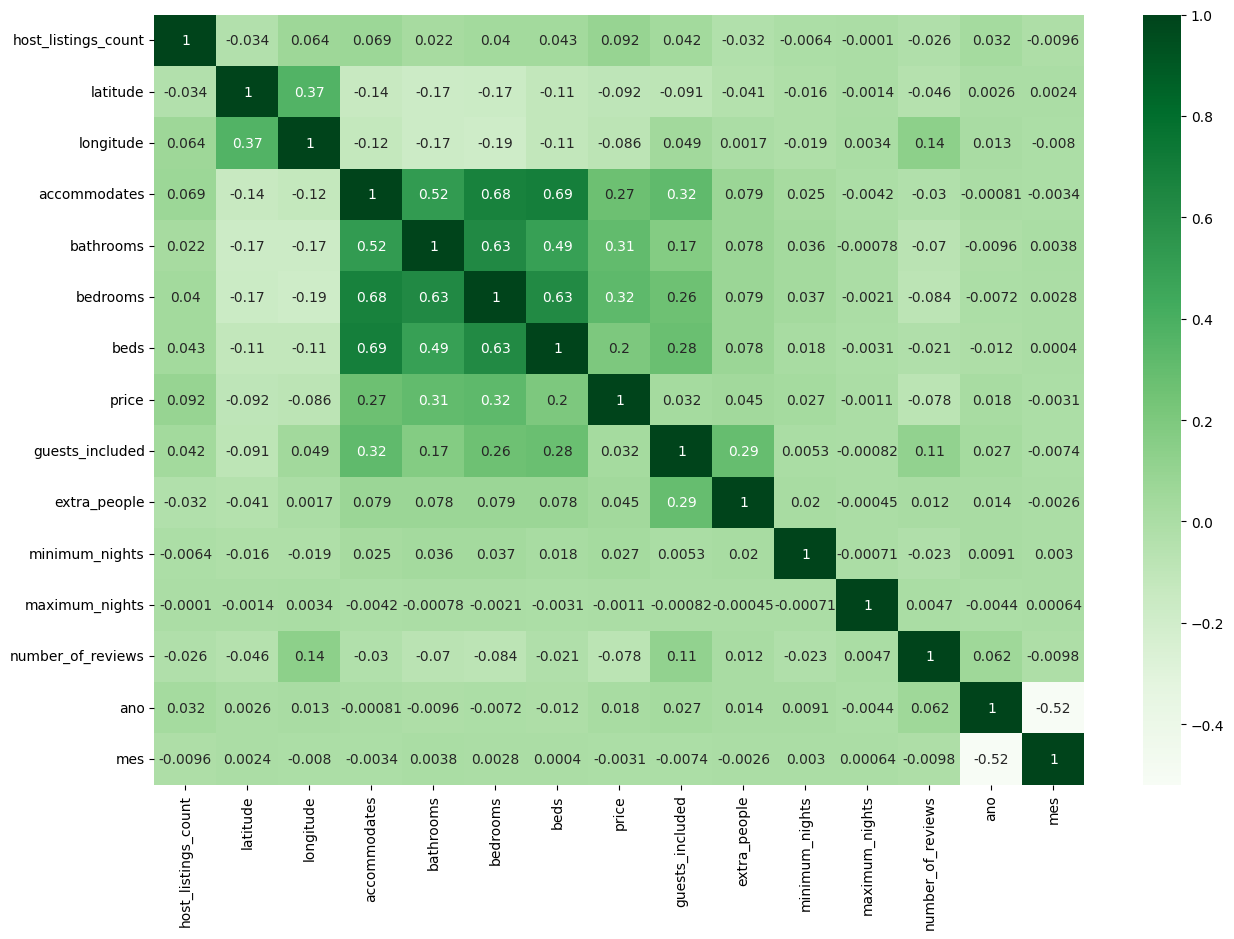

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.select_dtypes(include='number').corr(), annot=True, cmap='Greens');

### Definição de Funções para Ánalise de Outliers
Vamos definir funções para ajudar na análise de outliers das colunas

In [12]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup)]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [13]:
print(limites(base_airbnb['price'])) # exibe os limites inferior e superior para a coluna 'price'

(np.float64(-524.0), np.float64(1276.0))


In [14]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, kde=True, stat='density', bins=10)


def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Price

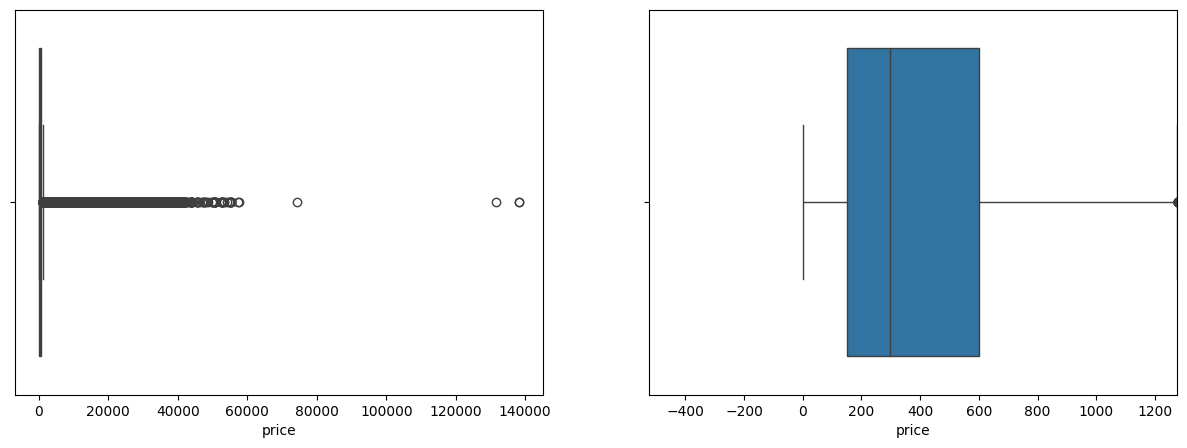

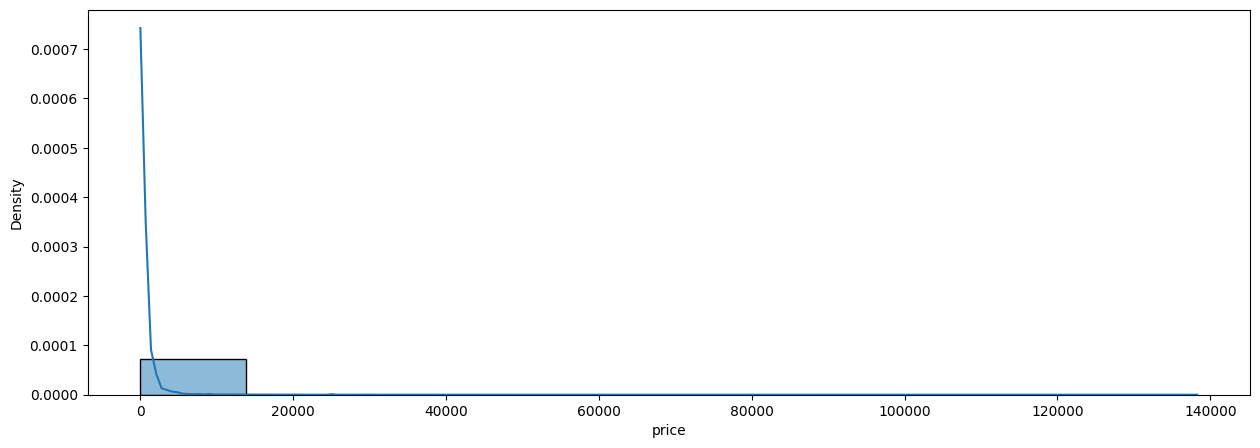

In [15]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos desenvolvendo um modelo voltado para imóveis padrão, valores muito acima do limite superior provavelmente correspondem a apartamentos de alto luxo, que não são o foco da nossa análise. Por isso, podemos remover esses outliers.

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


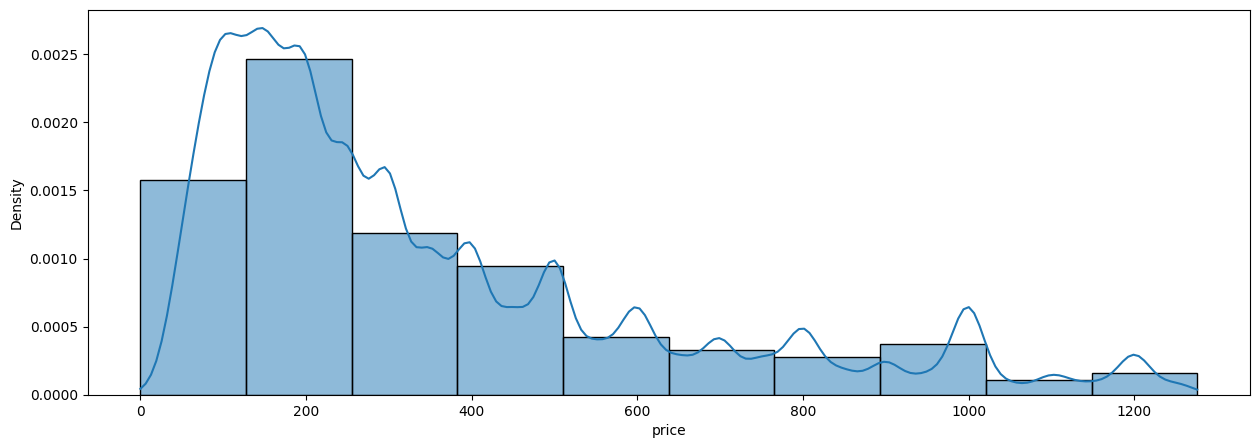

In [17]:
histograma(base_airbnb['price'])

### host_listings_count

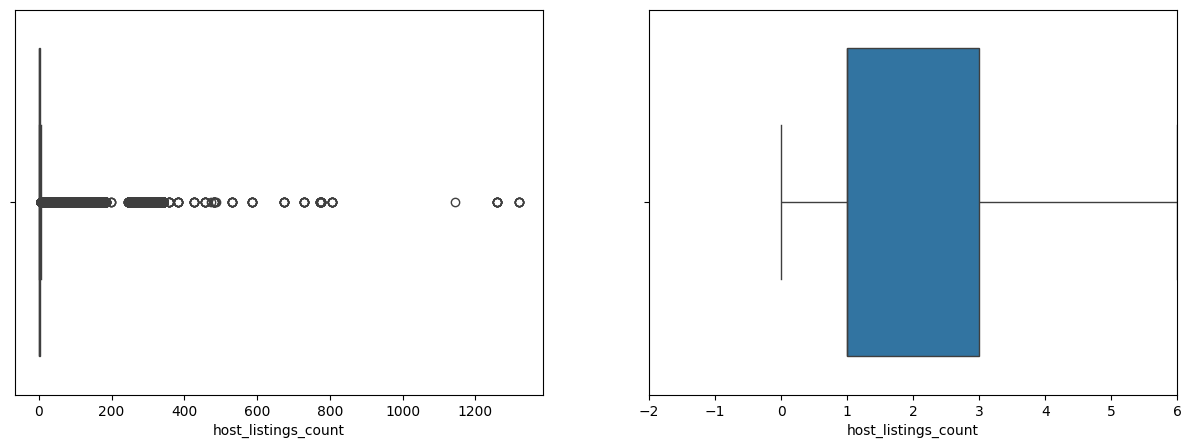

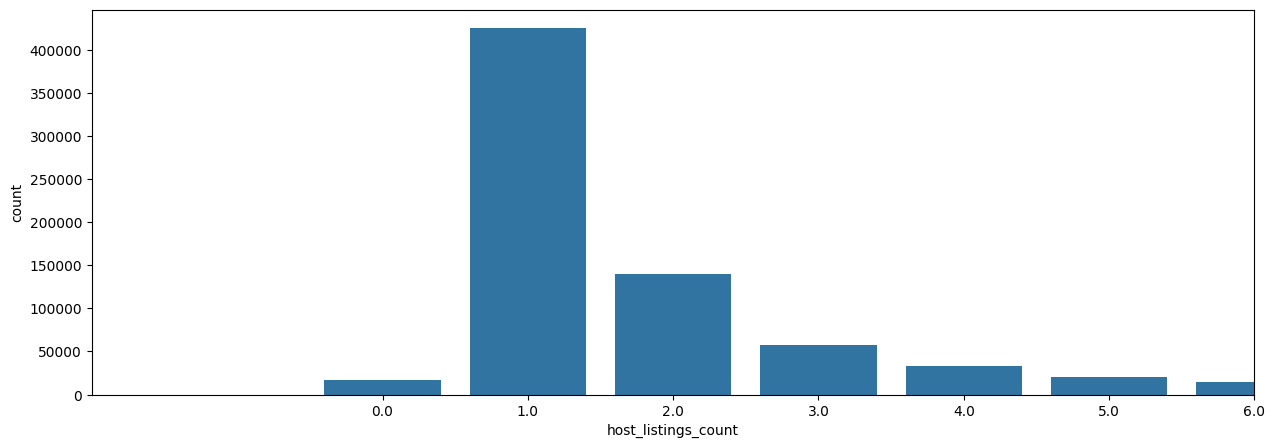

In [18]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers da coluna hos_listings_count, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no aibnb)

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

102813 linhas removidas


### Accommodates

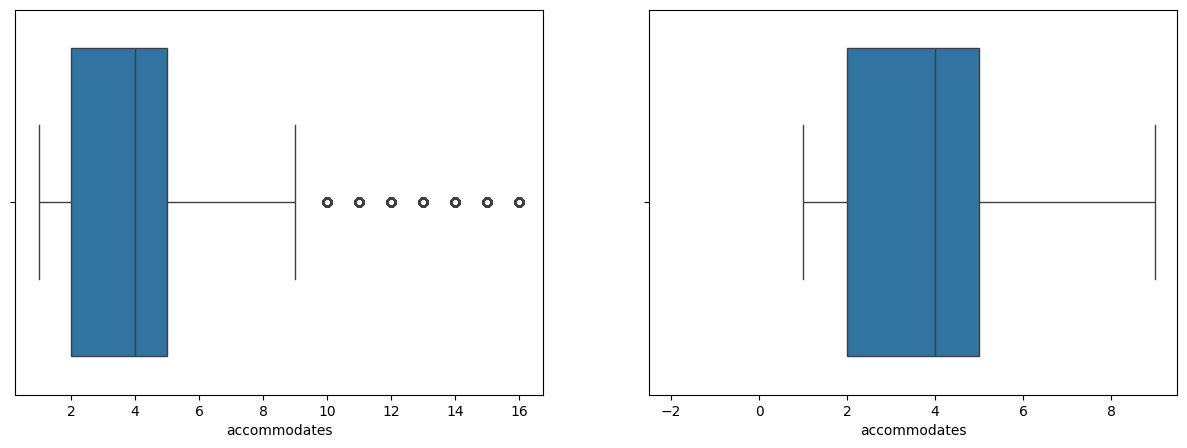

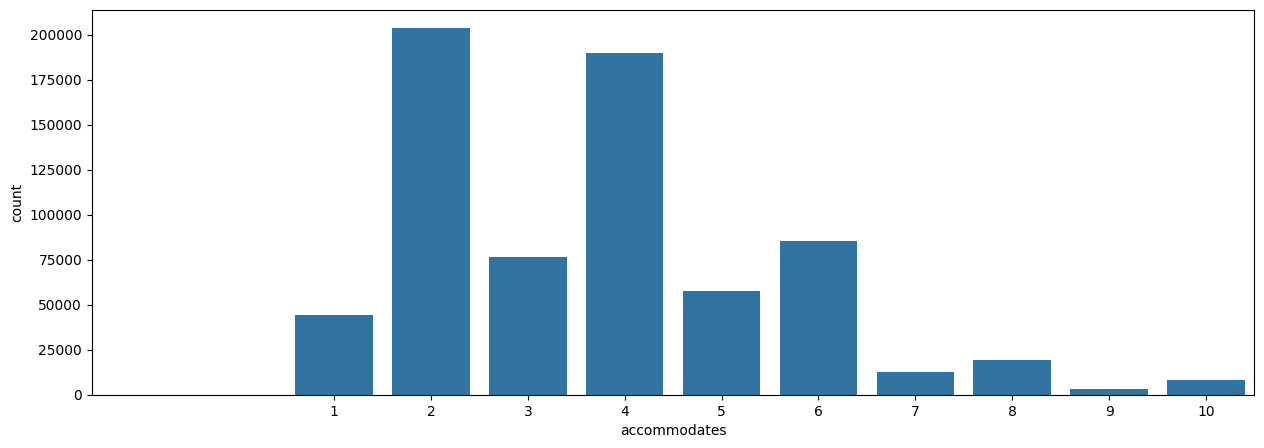

In [20]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

15241 linhas removidas


### Bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

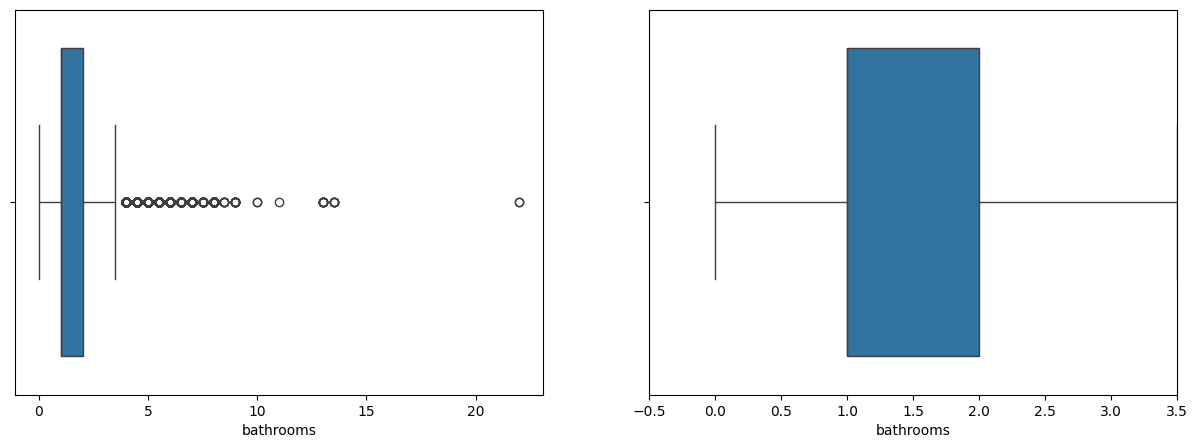

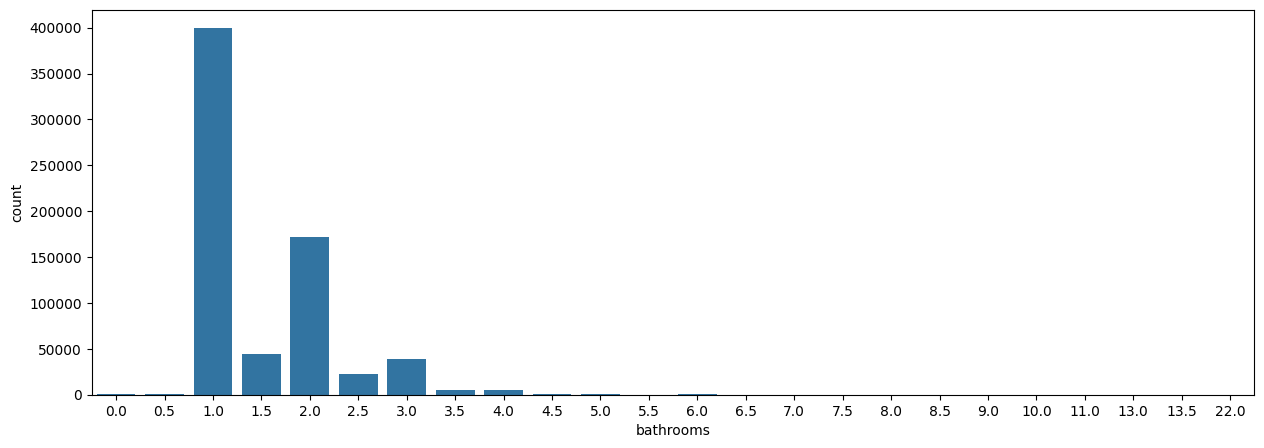

In [22]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

8311 linhas removidas


### Bedrooms

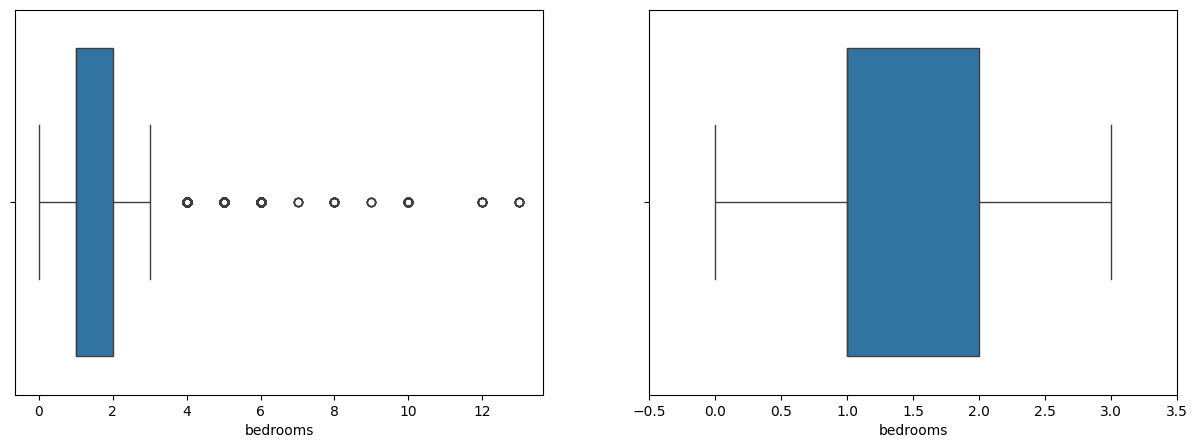

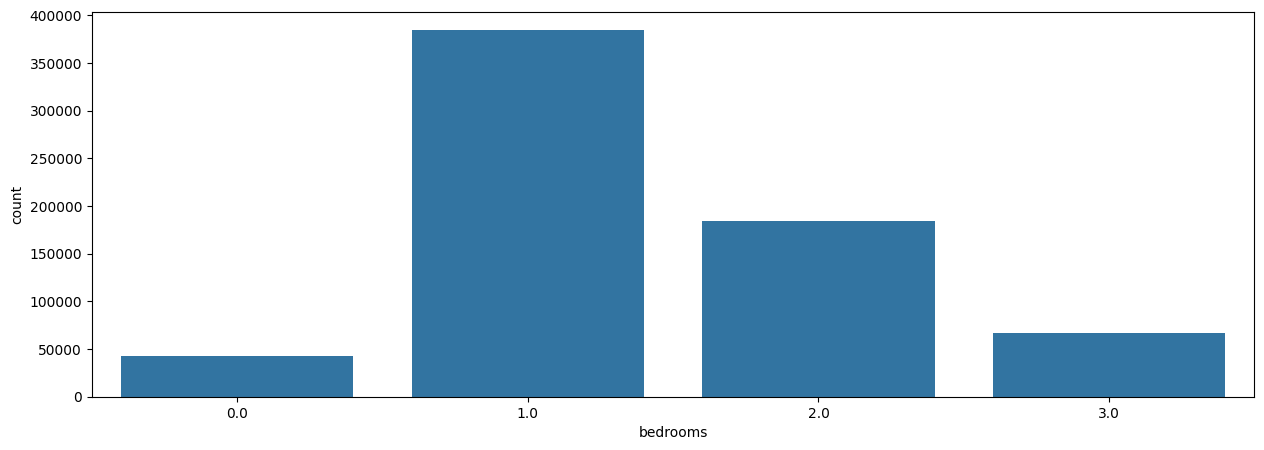

In [24]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

6588 linhas removidas


### beds

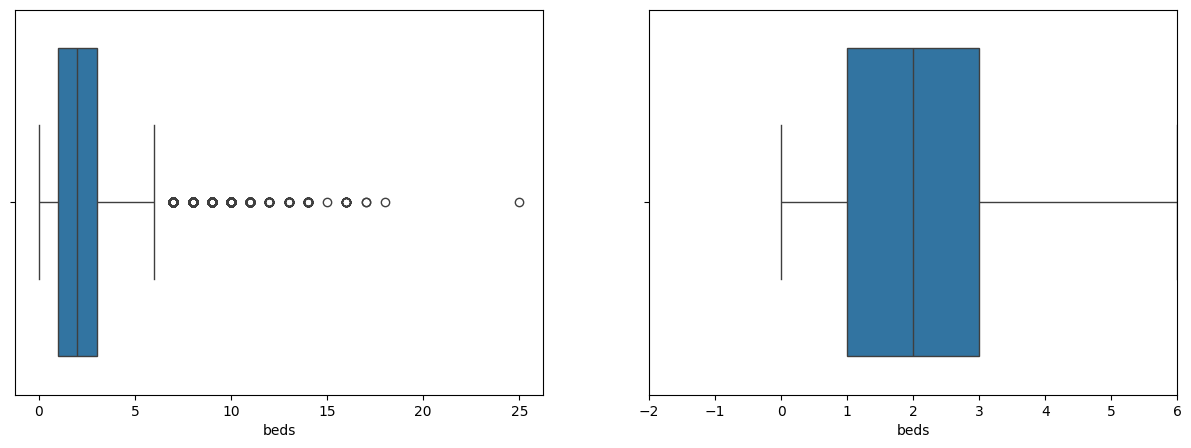

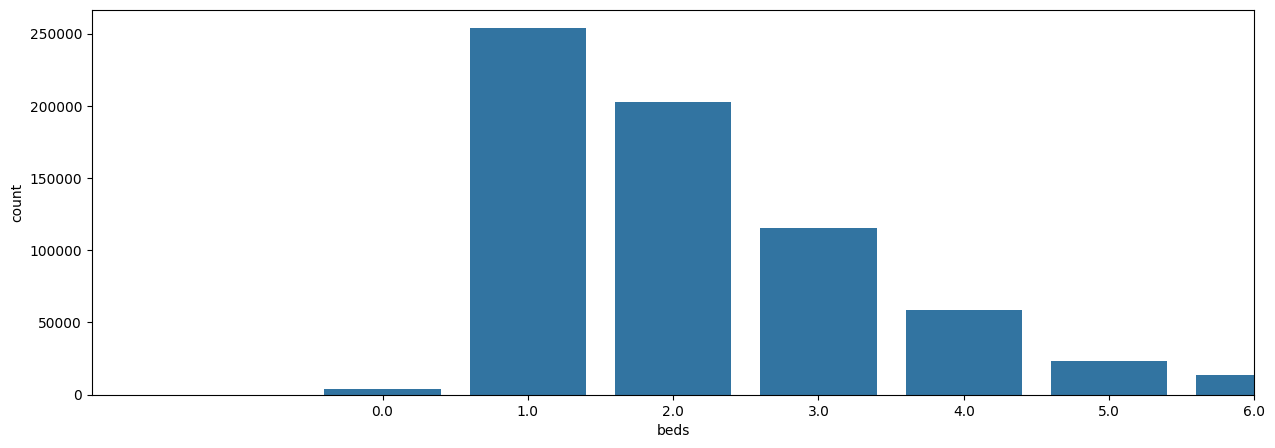

In [26]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

6345 linhas removidas


### guests_included

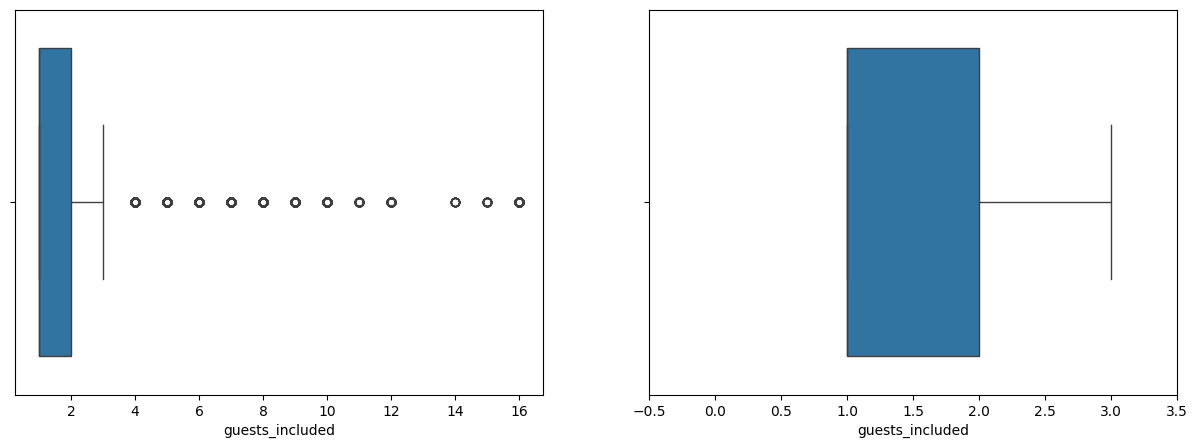

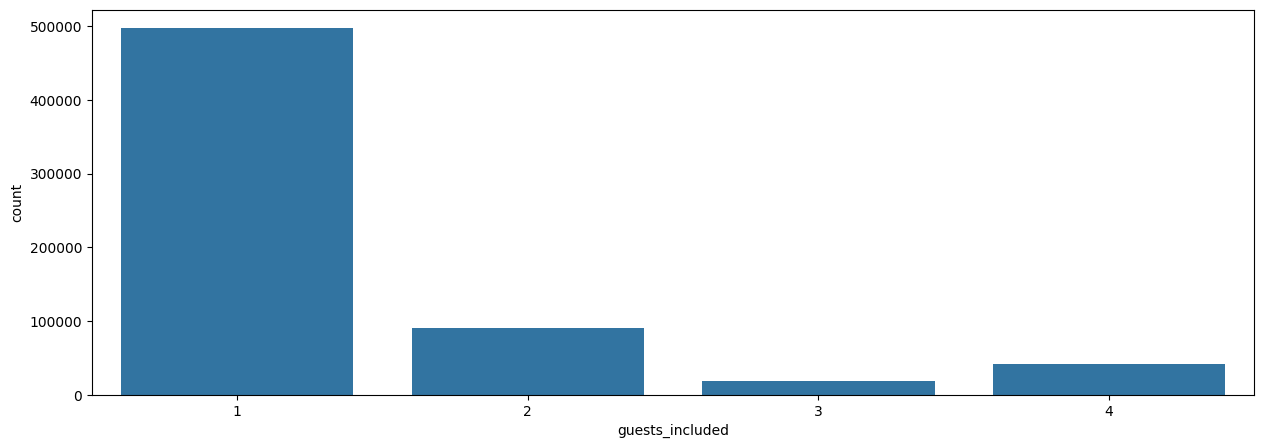

In [28]:
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise.

In [29]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(671129, 22)

### minimum_nights

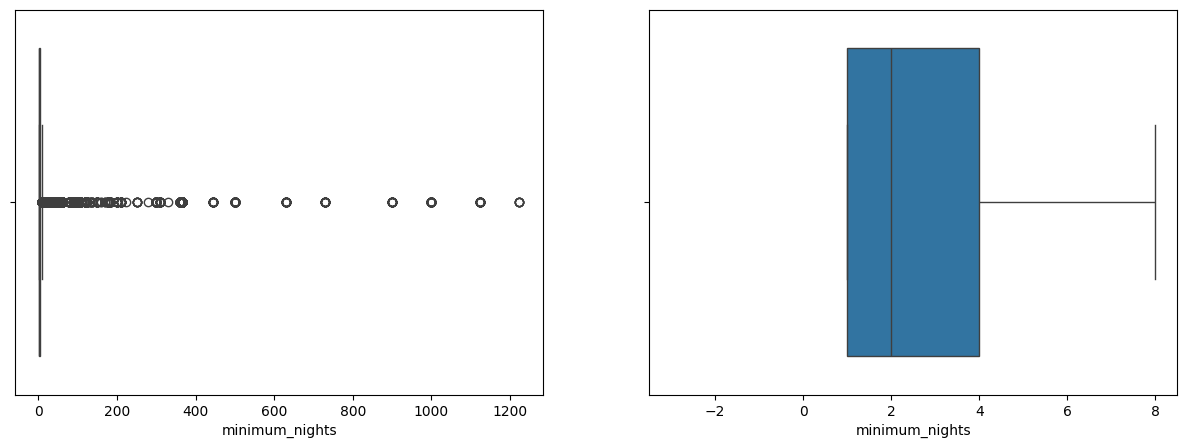

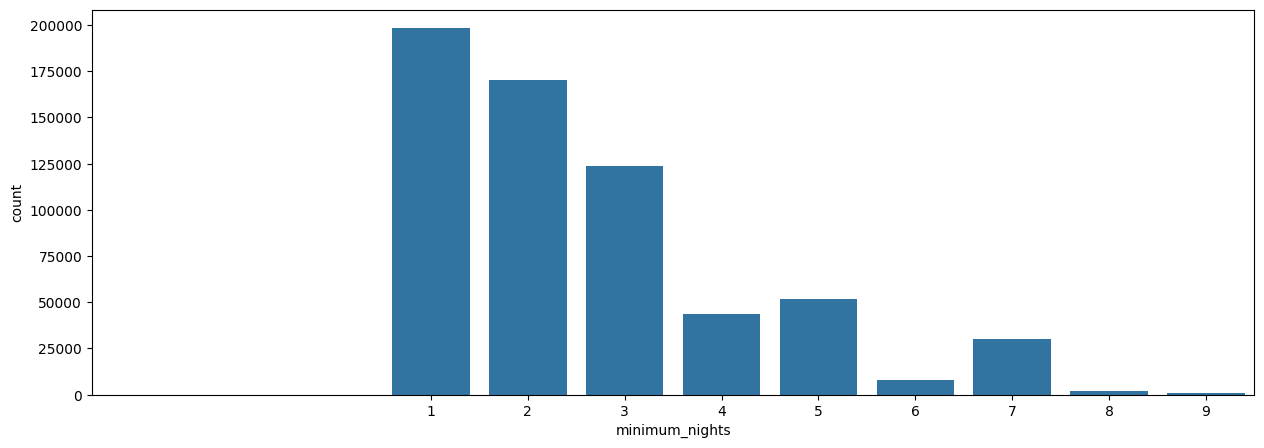

In [30]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

### maximum_nights

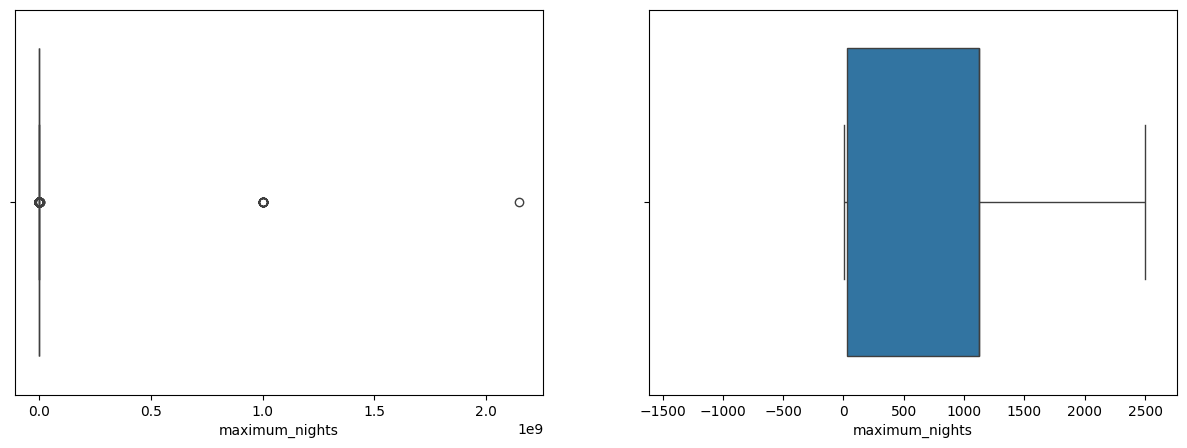

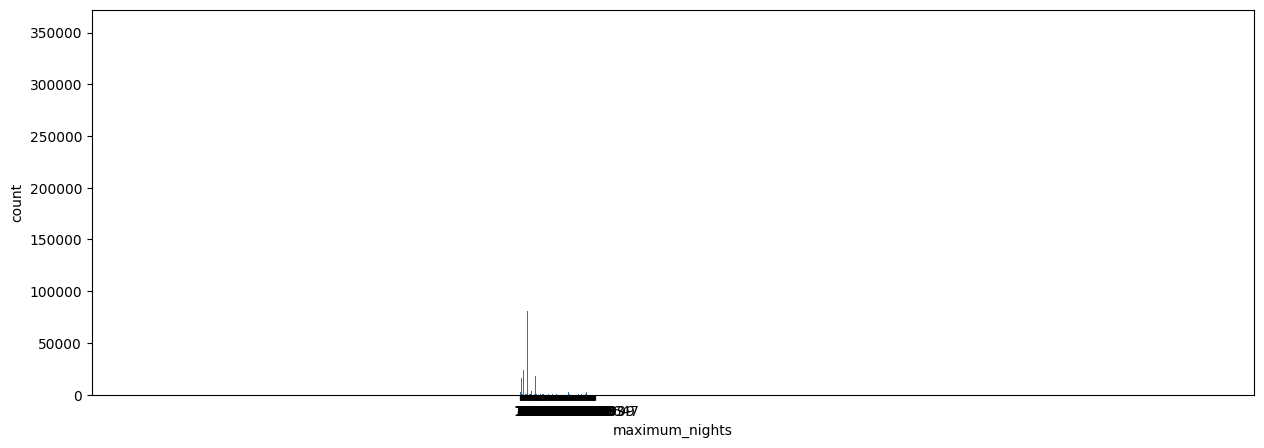

In [31]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

maximum_nights não fará sentido para a análise, pois o nosso objetivo é prever uma diária para um novo host na plataforma, não vamos levar em consideração estadia de longa duração

In [32]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(671129, 21)

### number_of_reviews


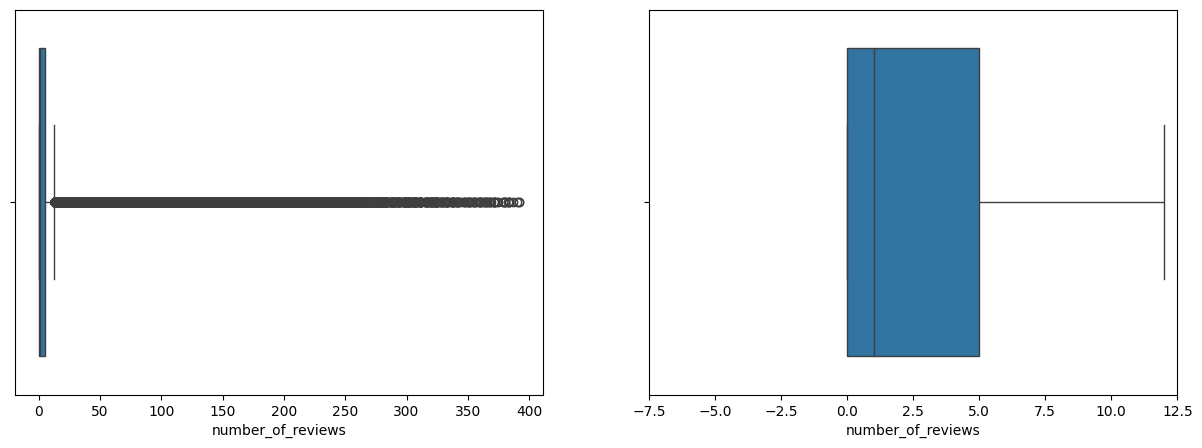

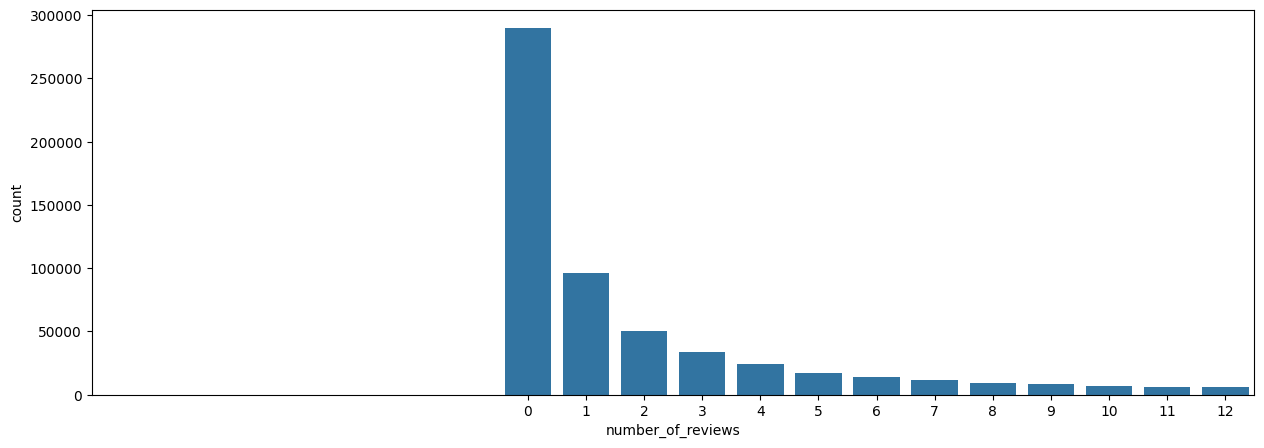

In [33]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

O objetivo do projeto é criar um modelo preditivo para pessoas que almejam anunciar o seu imóvel no Airbnb e saber quanto deverão cobrar a diária, provável que inicialmente os mesmos não terão reviews, então não faz sentido mantermos esta feature em nosso modelo, pois os hosts que possuem muitos reviews são hosts de longa data na plataforma, então vamos precisar tirar esta metrica em nossa análise, pois é capaz do nosso modelo utilizar precificação da diária de acordo com a quantidade de reviews, porém, para novos hosts inicialmente não vamos levar os reviews em consideração.

In [34]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(671129, 20)

In [35]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment                 532521
House                      58018
Condominium                30169
Serviced apartment         13964
Loft                       13745
Guest suite                 3955
Bed and breakfast           3674
Hostel                      2959
Guesthouse                  2363
Other                       2127
Villa                       1504
Townhouse                   1064
Aparthotel                   751
Earth house                  556
Chalet                       536
Tiny house                   496
Boutique hotel               491
Hotel                        383
Casa particular (Cuba)       335
Cottage                      255
Bungalow                     216
Dorm                         203
Cabin                        141
Nature lodge                 138
Castle                        80
Treehouse                     76
Boat                          66
Island                        54
Resort                        42
Hut                          

Vamos desconsiderar todos os tipos de propríedades fora do comum e focar em propríedades mais tradicionais no Aibnb, pois o nosso objetivo é prever o quanto um pessoa normal cobraria para anúnciar a sua casa ou apartamento pelo AIBNB.

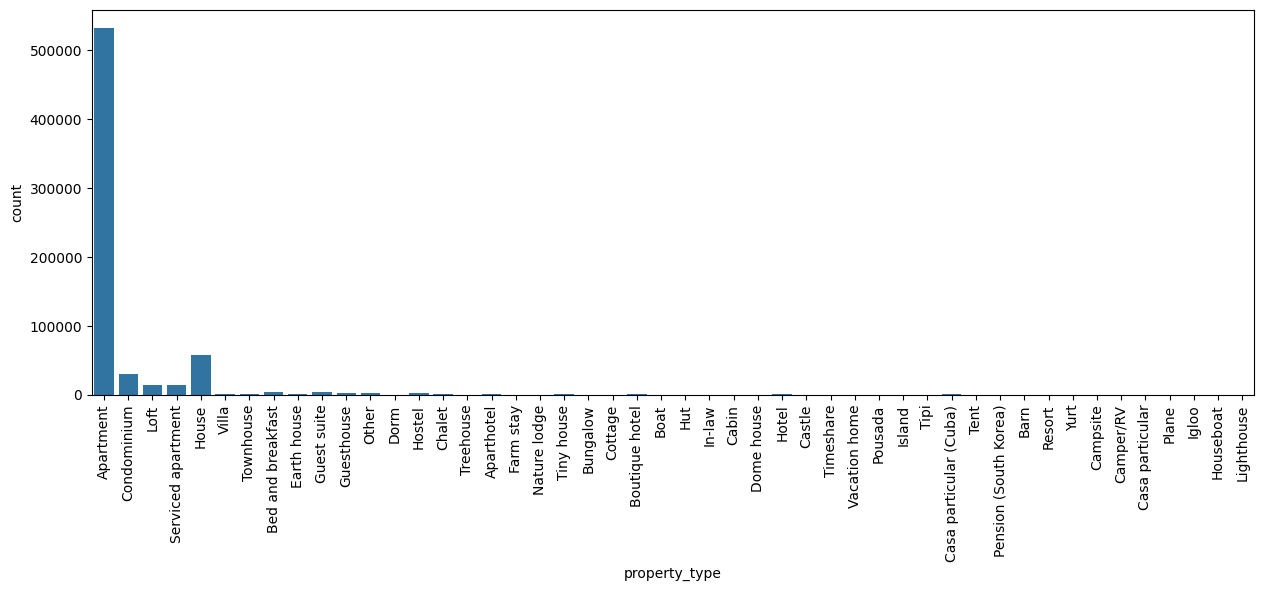

In [36]:
plt.figure(figsize=(15, 5))
sns.countplot(x='property_type', data=base_airbnb)
plt.xticks(rotation=90);


In [37]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)


for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'
print(base_airbnb['property_type'].value_counts())

['Villa', 'Townhouse', 'Aparthotel', 'Earth house', 'Chalet', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Boat', 'Island', 'Resort', 'Hut', 'Campsite', 'Tent', 'Camper/RV', 'Yurt', 'Tipi', 'Barn', 'Farm stay', 'Dome house', 'Pension (South Korea)', 'In-law', 'Igloo', 'Timeshare', 'Vacation home', 'Pousada', 'Casa particular', 'Houseboat', 'Plane', 'Lighthouse']
property_type
Apartment             532521
House                  58018
Condominium            30169
Serviced apartment     13964
Loft                   13745
Outros                  7634
Guest suite             3955
Bed and breakfast       3674
Hostel                  2959
Guesthouse              2363
Other                   2127
Name: count, dtype: int64


room_type

room_type
Entire home/apt    441047
Private room       215356
Shared room         13705
Hotel room           1021
Name: count, dtype: int64


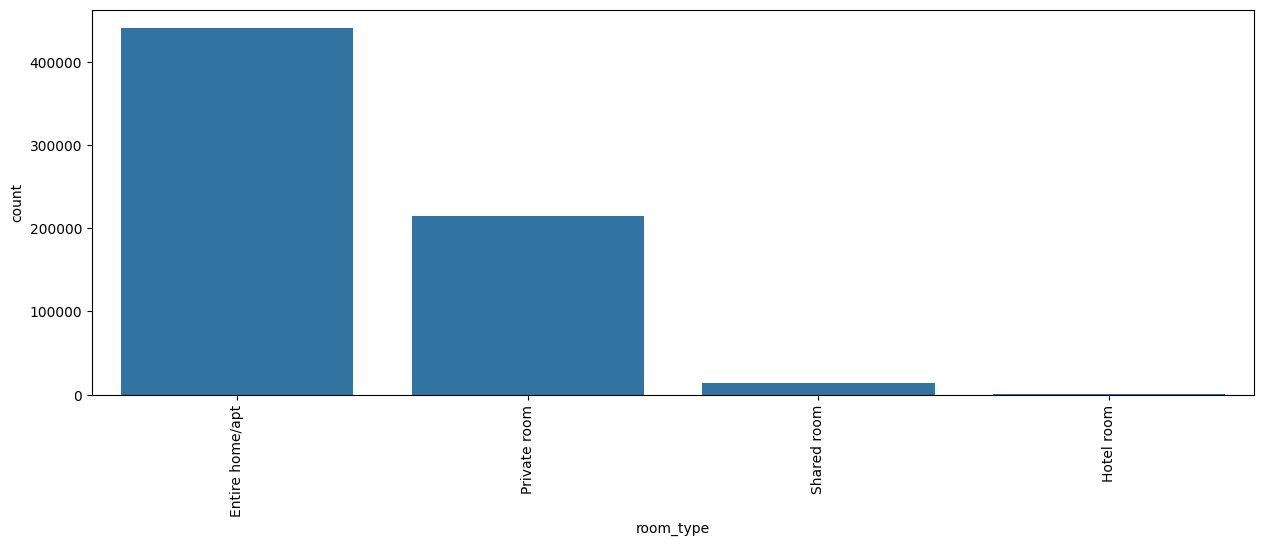

In [38]:
plt.figure(figsize=(15, 5))
sns.countplot(x='room_type', data=base_airbnb)
plt.xticks(rotation=90);

print(base_airbnb['room_type'].value_counts())

bed_type

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    658161
Outros       12968
Name: count, dtype: int64


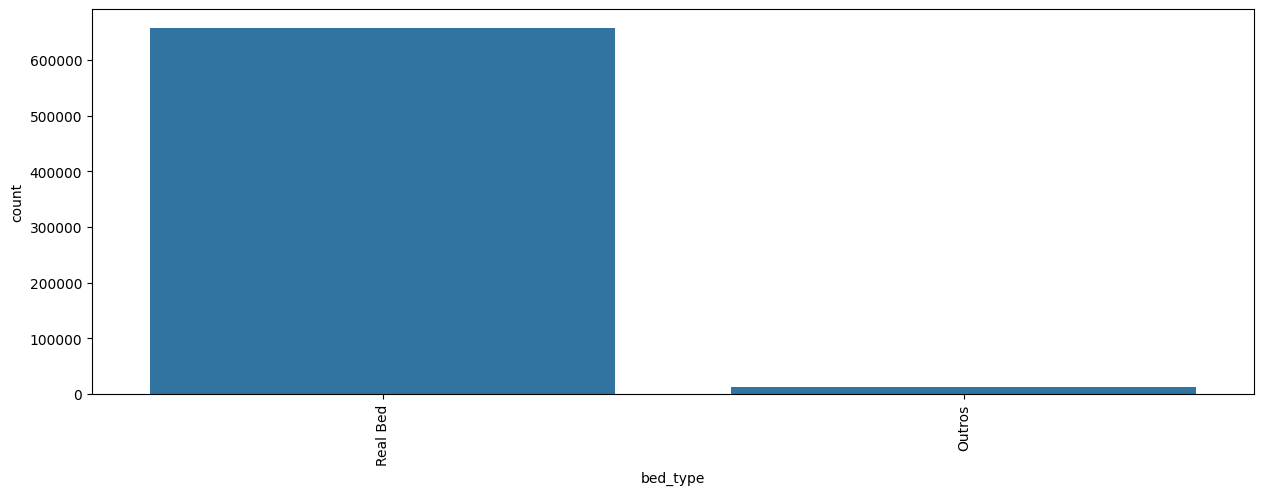

In [39]:

# agrupando categorias de bed_type

tabela_bed_type = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed_type.index:
    if tabela_bed_type[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)


for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
sns.countplot(x='bed_type', data=base_airbnb)
plt.xticks(rotation=90);

cancellation_policy

['super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       297308
strict_14_with_grace_period    235248
moderate                       127153
strict                          11420
Name: count, dtype: int64


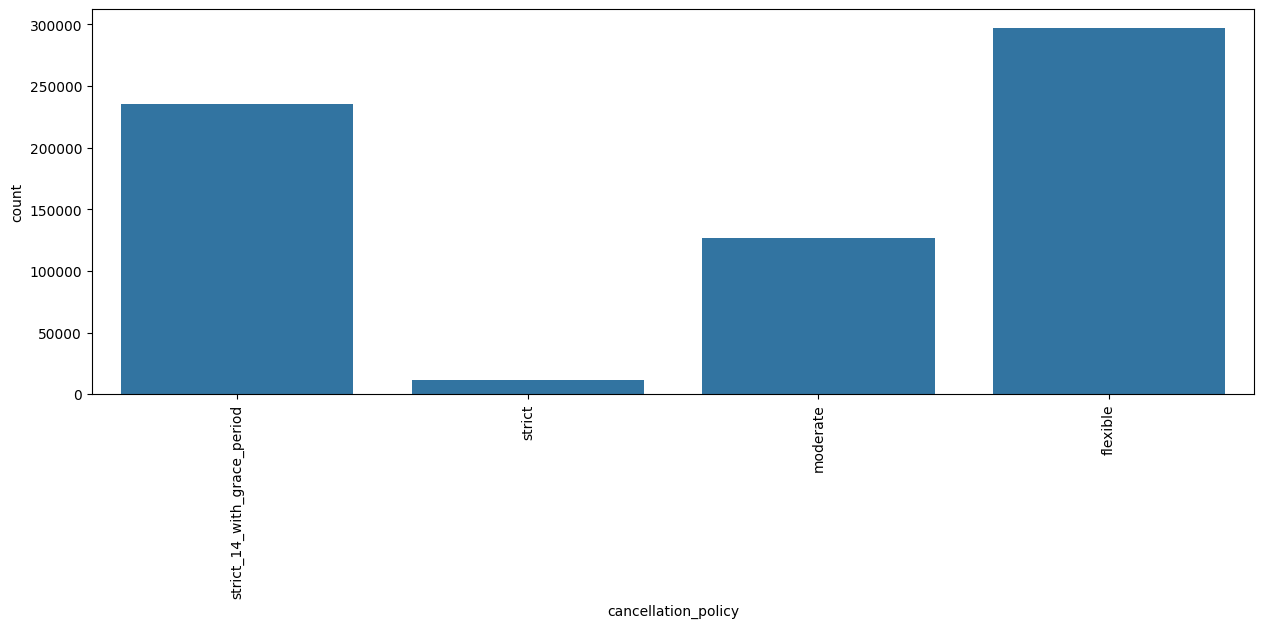

In [40]:

# agrupando categorias de cancellation_policy

tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)


for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
sns.countplot(x='cancellation_policy', data=base_airbnb)
plt.xticks(rotation=90);

Amenities

A coluna amenities contém muitos valores por linha, descrevendo a variedade de comodidades do host que irá disponibilizar para os clientes que irão alugar o seu imóvel, para usar a amenities como critério de qualidade, ao invés de fazer um super tratamento complexo em cima dessas lista de amenities, vamos contar a quantidade de comodidades que o host disponibiliza, ou seja, quanto mais amenities/comodidades o host disponibilizar, mais caro e mais bem avaliado será o imóvel do host.

In [41]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len) # conta a quantidade de itens na lista de amenities, separando por vírgula e aplicando a função len() para contar os itens

In [42]:
base_airbnb = base_airbnb.drop('amenities', axis=1) # remove a coluna 'amenities' do dataframe, pois já temos a coluna 'n_amenities' que conta a quantidade de amenities
base_airbnb.shape

(671129, 20)

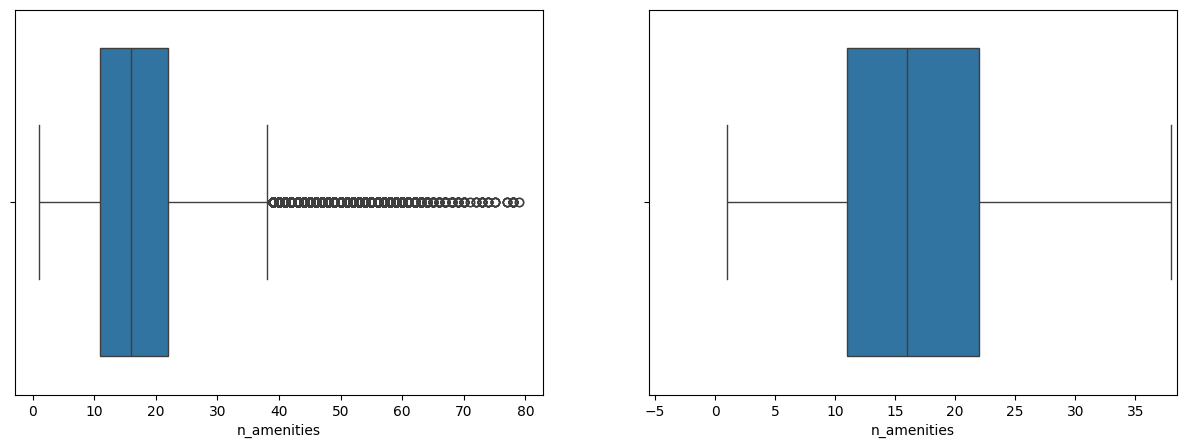

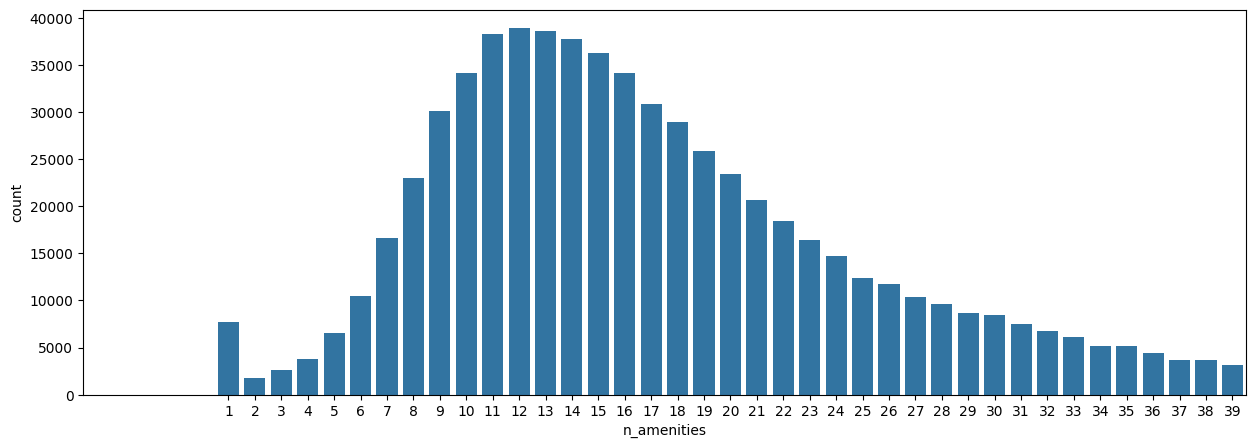

In [43]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

Vamos excluir os outliers de n_amenities que superam o limite superior de nossa distribuição de dados, pois estamos focando e prever a precificação de diárias para usuários comuns, n_amenities acima de 39 podem ser casos de imóveis mais luxuosos ou imóveis temáticos.

In [44]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

27272 linhas removidas


### visualização de mapa das imóveis disponíveis no AiRBNB Rio De Janeiro

In [45]:
amostra = base_airbnb.sample(n=50000) # Amostra aleatória de 50.000 registros
centro_mapa = {'lat': amostra['latitude'].mean(), 'lon': amostra['longitude'].mean()} # Centro do mapa 
mapa = px.density_map(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
center=centro_mapa, zoom=10, map_style='open-street-map') 

mapa.show()

Obviamente o gráfico retrata que a zona sul  do Rio de Janeiro possui os imóveis AIRBNB com as diárias mais caras do site, provável que o fator localização será um fatar relevante para o nosso modelo para precificar o preçp ideal de diárias para anunciar o imóvel no site airbnb 

### Enconding

Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)
- Os modelos preditivos precisam análisar todas as nossas features e cada valor que está ali dentro de cada feature e análisar o preço que está associado a esses valores das features, ou seja, para o modelo de machine learning ser treinado de forma precisa para prever o preço, o ML precisa ser modelado apenas com features numéricas, não podendo trabalhar com variáveis de texto.

A função do enconding é facilitar o treino do nosso moedelo de previsão, pois o modelo não consegue ler dados categóricos, apenas features numericas, todos as features categoricas precisam ser transformadas em features númericas true ou false ou 1 e 0.

Encoding é o processo de transformar variáveis categóricas (como texto ou rótulos) em valores numéricos, permitindo que modelos de machine learning consigam utilizá-las. A maior parte dos algoritmos trabalha apenas com números, já que internamente eles realizam cálculos matemáticos (como multiplicações de matrizes, distâncias ou gradientes).

vamos criar variáveis Dummies, ou One-Hot Encoding — ou seja, transformar cada categoria em uma coluna binária (0/1). Isso é muito usado quando o modelo não consegue lidar diretamente com rótulos inteiros, como regressões lineares, redes neurais, KNN, etc.

- Valores booleanos serão trocados por 1 e 0.
- Features de categoria, vamos utilizar método Dummies

In [46]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

In [47]:
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
     base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
     base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0


In [48]:
colunas_categoricas = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categoricas, dtype=int)

In [49]:
base_airbnb_cod.head()

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,0,1.0,-22.946854,-43.182737,4,1.0,0.0,2.0,133.0,34.0,...,1,0,0,0,0,1,0,0,0,1
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
2,0,1.0,-22.985698,-43.201935,2,1.0,1.0,1.0,222.0,215.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0


### Modelo de Previsão

- Métricas de avaliação

 Novamente, o nosso objetivo é prever o preço da diária dos imóveis
 - Vamos aplicar e desenvolver um modelo de regressão, pois queremos prever um número, ou seja: O preço ideal para uma pessoa comum que esteja interessada em anunciar o seu imóvel no Rio de Janeiro pelo AIRBNB 


In [50]:
def avalidar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}: \n R2: {r2}\n RSME: {RSME}'

- Escolha dos Modelos a serem testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    

In [51]:
modelos = {
'RandomForest': RandomForestRegressor(),
'ExtraTrees': ExtraTreesRegressor(),
'LinearRegression': LinearRegression()
}


y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Próximo Passo: Separar os dados em treino e teste + Treino do Modelo

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10) #garante que o “embaralhamento” seja sempre o mesmo, útil quando você quer que outras pessoas (ou você no futuro) consigam reproduzir exatamente o mesmo resultado.

for nome_modelo, modelo in modelos.items(): # Itera sobre os modelos definidos no dicionário
    modelo.fit(X_train, y_train) # Treina o modelo com os dados de treino
    previsao = modelo.predict(X_test) # Faz a previsão com os dados de X_test
    print(avalidar_modelo(nome_modelo, y_test, previsao))


Modelo RandomForest: 
 R2: 0.9739152444787523
 RSME: 45.019067221446136
Modelo ExtraTrees: 
 R2: 0.9781380989837181
 RSME: 41.21421846279291
Modelo LinearRegression: 
 R2: 0.31413650744736576
 RSME: 230.8457856003486


- R2: Quanto maior, melhor! Mede o quanto o modelo explica da variação dos dados (proporção explicada), em escala 0–1
- RSME: Quanto menor, melhor! Diz “quanto erro eu cometo (em unidades reais)?"

Vamos escolher o modelo que melhor explica e menos erra!

O nosso melhor modelo de previsão de acordo com o resultado foi o "Extra Trees" com o R2 e RSME melhor em relação aos outros modelos. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de "Random Forest" (que teve resultados próximos de R2 e RSME), vamos escolher o modelo "Extra Trees"

### Resultados das Métricas do Modelo Vencedor

**Modelo:** ExtraTrees  <br>
- **R²:** 97,81%  <br>
- **RMSE:** 41,21%  


### Ajustes e Melhorias no Melhor Modelo

In [53]:
extra_trees = modelos['ExtraTrees']

importancia_features = pd.DataFrame(extra_trees.feature_importances_, index=X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

,0
bedrooms,0.125722
longitude,0.100967
latitude,0.098636
n_amenities,0.091147
minimum_nights,0.088470
extra_people,0.076532
accommodates,0.069903
bathrooms,0.068493
room_type_Entire home/apt,0.066320
beds,0.051232


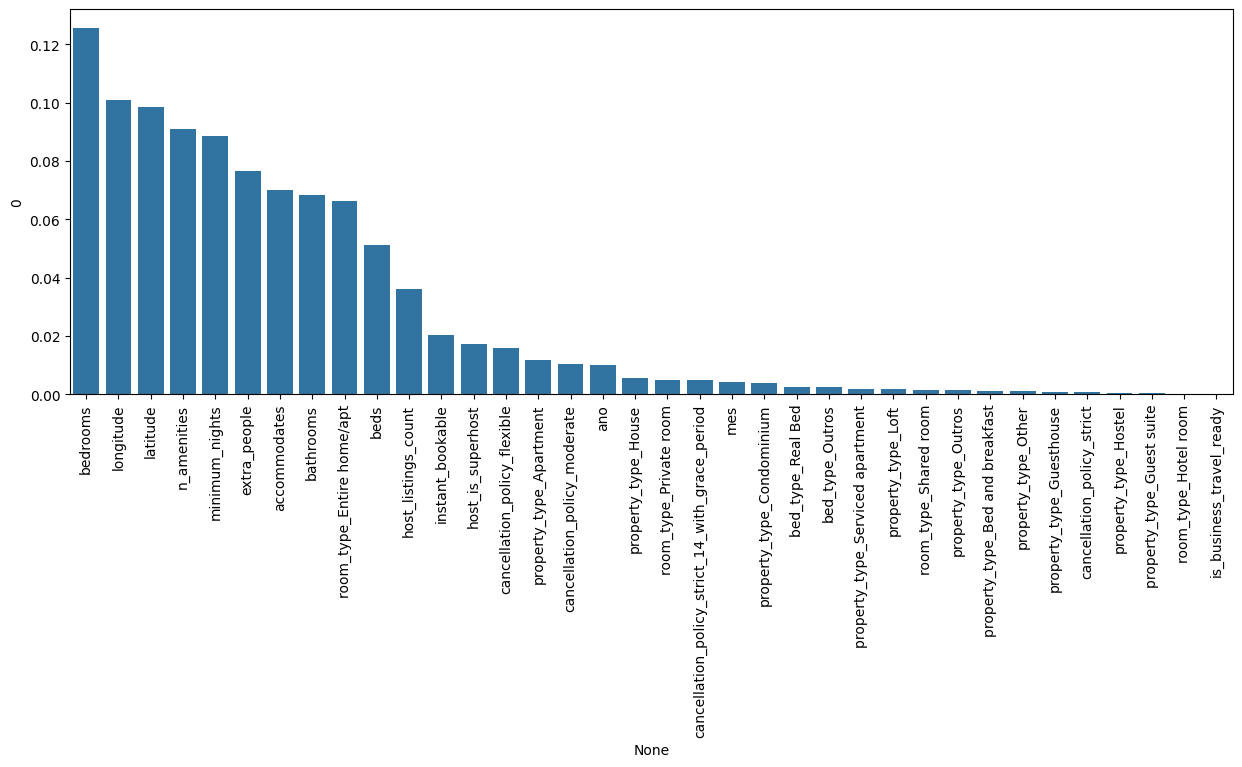

In [54]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90);

Vamos otimizar o nosso melhor modelo e descartar features que não fizeram tanta diferença em peso de importância para o nosso modelo extra trees prever da melhor maneira o preço do imóvel previsto para anunciar um imóvel no AIRBNB.


Ou seja, vamos remover features que não impactaram em nada para o nosso melhor modelo, fazendo o modelo ficar mais otimizado e rápido de rodar.


Vamos remover as features menos impactantes, treinar novamente o nosso modelo e testar com as features removidas para identificar se houve ou não mudanças negativas ou positivas na exclusão de features que não mostraram impacto expressivo no resultado de nosso modelo campeão (Extra Trees)

### Ajustes Finais no Modelo

- A variável is_business_travel_ready não demonstrou impacto relevante no desempenho do modelo.
 Assim, para simplificar, vamos removê-la e testar novamente o modelo sem essa feature.

In [55]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)

extra_trees.fit(X_train, y_train)
previsao = extra_trees.predict(X_test)

print(avalidar_modelo(extra_trees, y_test, previsao))

Modelo ExtraTreesRegressor(): 
 R2: 0.9780018881655412
 RSME: 41.3424119191237


Podemos perceber que o nosso R2 diminiui e RSME aumenta fracionalemnte, mas não impactou muito o resultado de explicação do nosso modelo de variação de dados, por isso vamos prosseguir sem a feature 'is_busniness_travel_ready', pois, quanto mais simples e menos features tivermos, menos generalisado e mais rápido e efetivo vai ser o nosso modelo campeão Extratress().

In [56]:
base_teste = base_airbnb_cod.copy()

for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)


y = base_teste['price']
x = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)

extra_trees.fit(X_train, y_train)
previsao = extra_trees.predict(X_test)

print(avalidar_modelo(extra_trees, y_test, previsao))

Modelo ExtraTreesRegressor(): 
 R2: 0.9779537963668395
 RSME: 41.38757819284927


Novamente o nosso modelo piorou, mas muito pouco, não comprometendo significamente o resultado do modelo campeão ExtraTreesRegressor(), continuando sendo o melhor modelo, agora com menos 3 features, fazendo o nosso modelo menos generalizado e mais rápido de rodar.

## Deploy do Projeto

1. **Criar arquivo do modelo** (com `joblib`)  
2. **Escolher a forma de deploy**:  
   - Arquivo Executável + Tkinter  
   - Microsite com Flask  
   - Uso direto com Streamlit  
3. **Criar outro arquivo Python** (pode ser em Jupyter ou PyCharm)  
4. **Importar Streamlit e desenvolver o código**  
5. **Atribuir o carregamento do modelo** ao botão no Streamlit  
6. **Finalizar o deploy** 


In [57]:
x['price'] = y 
x.to_csv('dados.csv')

In [ ]:
import joblib

joblib.dump(extra_trees, 'modelo.joblib') #salvar e carregar objetos Python de forma eficiente

['modelo.joblib']